# Hands-On Tutorial: Automated Predictive (APL) in SAP HANA Cloud
## Train Machine Learning Model
https://blogs.sap.com/2020/07/27/hands-on-tutorial-automated-predictive-apl-in-sap-hana-cloud/

In [5]:
import hana_ml
print(hana_ml.__version__)

2.18.23092701


### Connect to SAP HANA Cloud

In [2]:
import hana_ml.dataframe as dataframe
conn = dataframe.ConnectionContext(userkey = 'MYHC',
                                   encrypt = 'true')
conn.connection.isconnected()

True

### Training data

Point to the data in SAP HANA Cloud. Add a sort to ensure reproducability

In [4]:
df_remote = conn.table(table = 'BANKMARKETING').sort('CUSTOMER_ID', desc = False)
df_remote.head(5).collect()

,CUSTOMER_ID,AGE,JOB,MARITAL,EDUCATION,DEFAULT,BALANCE,HOUSING,LOAN,CONTACT,DAY,MONTH,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME,PURCHASE
0,0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,no
1,1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,no
2,2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,no
3,3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,no
4,4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,no


### Train Machine Learning model

In [26]:
from hana_ml.algorithms.apl.gradient_boosting_classification import GradientBoostingBinaryClassifier
gbapl_model = GradientBoostingBinaryClassifier()

Specify what to predict, and the ID column 

In [ ]:
col_target = 'PURCHASE'
target_value = 'yes'
col_id = 'CUSTOMER_ID'

Specify the predictors (exclude the target column and the ID)

In [27]:
col_predictors = df_remote.columns
col_predictors.remove(col_target)
col_predictors.remove(col_id)
col_predictors

['AGE',
 'JOB',
 'MARITAL',
 'EDUCATION',
 'DEFAULT',
 'BALANCE',
 'HOUSING',
 'LOAN',
 'CONTACT',
 'DAY',
 'MONTH',
 'CAMPAIGN',
 'PDAYS',
 'PREVIOUS',
 'POUTCOME']

Further configuration for the model training

In [10]:
gbapl_model.set_params(eval_metric = 'AUC') # Metric used to evaluate the model performance
gbapl_model.set_params(cutting_strategy = 'random with no test') # Internal splitting strategy
gbapl_model.set_params(other_train_apl_aliases={'APL/VariableAutoSelection': 'true', 
                                                'APL/Interactions': 'true',
                                                'APL/InteractionsMaxKept': 10, 
                                                'APL/TargetKey': target_value})

Train the Machine Learning model in SAP HANA Cloud

In [28]:
gbapl_model.fit(data = df_remote, 
                key = col_id, 
                features = col_predictors, 
                label = col_target)

### Explore trained Machine Learning model

Model quality

In [29]:
import pandas as pd
list_performance = gbapl_model.get_performance_metrics()
df_performance = pd.DataFrame(list(list_performance.items()), columns=['METRIC', 'VALUE'])
df_performance.loc[df_performance['METRIC'].isin(['AUC', 'BestIteration'])].style.hide(axis='index')

METRIC,VALUE
AUC,0.791900
BestIteration,124


Model details

In [30]:
df_summary = gbapl_model.get_summary().filter("KEY in ('ModelVariableCount', 'ModelSelectedVariableCount', 'ModelRecordCount', 'ModelBuildDate')").collect()
df_summary = df_summary[['KEY','VALUE']]
df_summary['KEY'] = df_summary['KEY'].str.replace('Model', '').str.replace('Selected', 'Selected ')
df_summary['KEY'] = df_summary['KEY'].str.replace('Count', ' Count').str.replace('Date', ' Date')
df_summary.style.hide(axis='index')

KEY,VALUE
Variable Count,17
Selected Variable Count,15
Record Count,45211
Build Date,2023-10-11 10:09:53


Excluded variables

In [14]:
df_excluded = gbapl_model.get_indicators().filter("KEY like 'VariableExclusion%'").collect()
df_excluded = df_excluded[['VARIABLE','VALUE']]
df_excluded.columns = ['Excluded Variable', 'Reason']
df_excluded.style.hide(axis='index')

Excluded Variable,Reason
DEFAULT,Low contributory
JOB,Low contributory
PDAYS,Low contributory


Variables selected by the model

In [31]:
list_contributions = gbapl_model.get_feature_importances()['ExactSHAP']
df_contribution = pd.DataFrame(list(list_contributions.items()), columns=['VARIABLE', 'CONTRIBUTION'])
df_contribution['CUMULATIVE'] = df_contribution['CONTRIBUTION'].cumsum()
format_dict = {'CONTRIBUTION':'{0:,.2%}','CUMULATIVE':'{0:,.2%}'}
df_contribution.style.format(format_dict).hide(axis='index')

VARIABLE,CONTRIBUTION,CUMULATIVE
CONTACT,20.84%,20.84%
MONTH,12.40%,33.24%
PREVIOUS,11.31%,44.55%
HOUSING,8.43%,52.98%
BALANCE,7.35%,60.33%
DAY,7.20%,67.53%
POUTCOME,6.26%,73.79%
MARITAL,5.86%,79.65%
AGE,5.74%,85.39%
CAMPAIGN,5.58%,90.97%


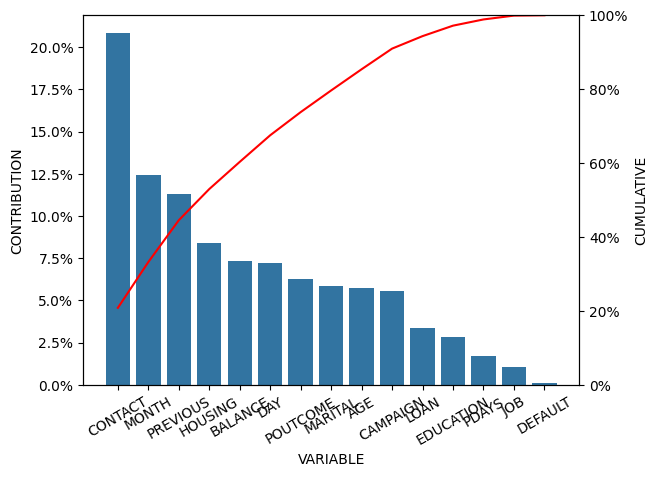

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from  matplotlib.ticker import PercentFormatter
f = plt.figure()
ax1 = f.add_subplot(111) # 111 refers to 1x1 grid, 1st subplot
ax2 = ax1.twinx()
sns.barplot(data = df_contribution, 
             x = 'VARIABLE', 
             y = 'CONTRIBUTION',
             color = '#1f77b4',
             ax=ax1)
sns.lineplot(data = df_contribution, sort=False,
             x = 'VARIABLE', 
             y = 'CUMULATIVE',
             color = 'red',
             ax=ax2)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=30)
ax1.yaxis.set_major_formatter(PercentFormatter(1))
ax2.yaxis.set_major_formatter(PercentFormatter(1))
ax2.set_ylim(0, 1)
plt.show();

Impact by individual variable

In [33]:
variable_name = 'MONTH'
df_category_profit = gbapl_model.get_indicators().filter("KEY = 'GroupNormalProfit' and VARIABLE = '" + variable_name + "'").collect()
df_category_profit = df_category_profit[['VARIABLE', 'TARGET', 'DETAIL', 'VALUE']]
df_category_profit['VALUE'] = df_category_profit['VALUE'].astype(float)
df_category_profit.columns = ['Predictor', 'Target','Category','Profit']
df_category_profit = df_category_profit.sort_values(by = ['Profit'], ascending = False)
df_category_profit.style.format({'Profit':'{0:,.2%}'}).hide(axis='index')

Predictor,Target,Category,Profit
MONTH,PURCHASE,{dec;mar;oct;sep},36.65%
MONTH,PURCHASE,{apr},8.23%
MONTH,PURCHASE,{feb},5.63%
MONTH,PURCHASE,{aug;nov},-1.21%
MONTH,PURCHASE,{jan;jul;jun},-2.00%
MONTH,PURCHASE,{may},-4.98%


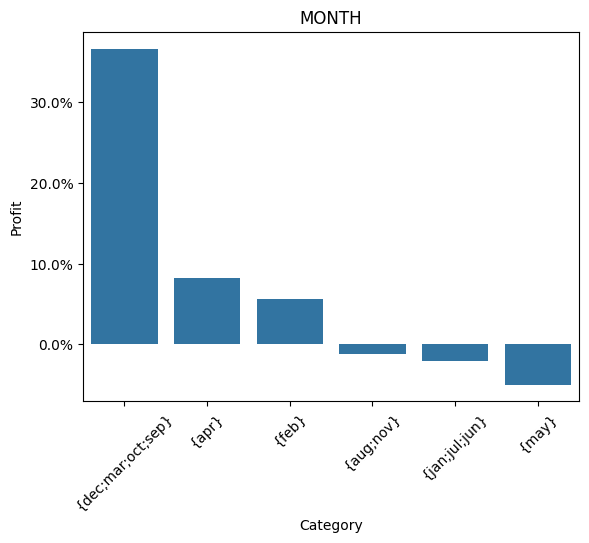

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
plt.figure()
bplot = sns.barplot(data = df_category_profit, x = 'Category', y = 'Profit', color = '#1f77b4')
bplot.set_title(variable_name)
bplot.set_xticklabels(bplot.get_xticklabels(), rotation = 45);
bplot.yaxis.set_major_formatter(PercentFormatter(1))

Correlations

In [35]:
df_correlations = gbapl_model.get_indicators().filter("KEY = 'CorrelatedVariable'").collect()
df_correlations = df_correlations[['VARIABLE', 'DETAIL', 'VALUE']]
df_correlations['VALUE'] = df_correlations['VALUE'].astype(float).round(3)
df_correlations.columns = ['1st Variable', '2nd Variable', 'Coefficient']
df_correlations = df_correlations.sort_values(by = ['Coefficient'], ascending = False)
df_correlations.style.hide(axis='index')

1st Variable,2nd Variable,Coefficient
PDAYS,PREVIOUS,0.740000
PDAYS,POUTCOME,0.570000
PREVIOUS,POUTCOME,0.520000


Interactions

In [22]:
df_interactions = gbapl_model.get_indicators().filter("KEY = 'InteractionValue' and to_char(VALUE) <> '0'").collect()
df_interactions = df_interactions[['VARIABLE', 'DETAIL', 'VALUE']]
df_interactions['VALUE'] = df_interactions['VALUE'].astype(float).round(3)
df_interactions.columns = ['1st Variable', '2nd Variable', 'Interaction']
df_interactions = df_interactions.sort_values(by = ['Interaction'], ascending = False)
df_interactions.head(10).style.format({'Interaction':'{0:,.3f}'}).hide(axis='index')

1st Variable,2nd Variable,Interaction
POUTCOME,PREVIOUS,0.095
PREVIOUS,POUTCOME,0.095
DAY,MONTH,0.095
MONTH,DAY,0.095
CONTACT,MONTH,0.080
MONTH,CONTACT,0.080
CONTACT,HOUSING,0.035
HOUSING,CONTACT,0.035
POUTCOME,MONTH,0.027
MONTH,POUTCOME,0.027


Logic of the predicted behaviour / probability

In [37]:
df_threshold = gbapl_model.get_indicators().filter("KEY = 'Threshold'").collect()
df_threshold = df_threshold[['VARIABLE', 'VALUE']]
df_threshold['VALUE'] = df_threshold['VALUE'].astype(float)
df_threshold.columns = ['Target', 'Score Treshold']
df_threshold.style.hide(axis='index')

Target,Score Treshold
PURCHASE,-1.226383


In [24]:
import math
score = df_threshold.iloc[0, 1]
1 / (1 + math.exp(-score))

0.2316465597885017

### Save the model

In [25]:
from hana_ml.model_storage import ModelStorage
model_storage = ModelStorage(connection_context=conn)
gbapl_model.name = 'Bank Marketing Model'
model_storage.save_model(model=gbapl_model, if_exists = 'replace')